In [3]:
%load_ext autoreload
%autoreload 2

import sys
import os
import jax
import jax.numpy as jnp
from jax import jit
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from jax.typing import ArrayLike

sys.path.append("JohnnyBotSimulator.")


# Dynamically determine the path to the JohnnyBotSimulator directory
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

from Dynamics.JohnnyDynamics import JohnnyDynamics
from Controller.JohnnyControl import JohnnyController
from Estimation.PNT_Estimation import PNT_Estimation

import cvxpy as cp



In [4]:
class DynamicallyExtendedUnicycle:

    def __call__(self, state, control):
        return self.drift_dynamics(state) + self.control_matrix(state) @ control

    def drift_dynamics(self, state: ArrayLike) -> tuple:
        '''
        The "drift" term which is the nonlinear term that does not depend on control
        Takes state as an input
        '''
        _, _, theta, v = state
        return jnp.array([v * jnp.cos(theta),
                        v * jnp.sin(theta),
                        0.,
                        0.])
    
    def dynamics2(self, state: ArrayLike, control: ArrayLike) -> tuple:
        A = jnp.array([[0, 0, 1, 0],
                       [0, 0, 0, 1],
                       [0, 0, 0, 0],
                       [0, 0, 0, 0]])
        
        B = jnp.array([[0, 0],
                       [0, 0],
                       [1, 0],
                       [0, 1]])
        
        state_derivative = A @ state + B @ control
        #print("State derivative: ")
        #print(state_derivative)

        
        return state_derivative

    def control_matrix(self, state: ArrayLike):
        '''
        The control matrix B(x) assuming a control affine system.
        In general, it may be state depedent, thus takes state as an input
        Here, we scaled the control input so we have omega and acceleration between [-1, 1]
        '''
        return jnp.array([[0, 0.],
                          [0, 0.],
                          [jnp.pi/2, 0.],
                          [0., 3.]])


dynamics = DynamicallyExtendedUnicycle()

In [5]:
testA = JohnnyController()

In [8]:
def barrier_function(state, r=3):
    x, y, theta, v = state
    return (x-3)**2 + (y-3)**2 - r**2


# linearization of dynamics
def linearize_autodiff3(state, control, func_dynamics): 

    func_x = jit(jax.jacfwd(func_dynamics, argnums=0))
    func_u = jit(jax.jacfwd(func_dynamics, argnums=1))

    A = func_x(state, control)
    B = func_u(state, control)

    return A, B

def lie_derivative(func, vector_field_func, state):
    '''
    func: a function that takes in a state and returns a scalar value.
          i.e., func(state) = scalar
    vector_field_func: a function that takes in a state and returns a
                      vector/matrix. i.e., func(state) = vector/matrix
    state: an array describing the state which is the input to func and
          vector_field_func
    '''

    func_gradx = jax.jacobian(func)
    #func_gradu = jax.jacobian(vector_field_func, argnums=1)
    
    lie = jnp.matmul(func_gradx(state).T, vector_field_func(state))
     
    return lie

def lie_derivative2(func, vector_field_func, state, control):
    '''
    func: a function that takes in a state and returns a scalar value.
          i.e., func(state) = scalar
    vector_field_func: a function that takes in a state and returns a
                      vector/matrix. i.e., func(state) = vector/matrix
    state: an array describing the state which is the input to func and
          vector_field_func
    '''

    func_gradx = jax.jacobian(func)
    #func_gradu = jax.jacobian(vector_field_func, argnums=1)
    state = jnp.array(state)

    lie = jnp.matmul(func_gradx(state).T, vector_field_func(state,control))
     
    return lie

def control_constraint_degree_2(h, dynamics, state, control, class_K_funcs):
    '''
    h: a function that takes in a state and returns a scalar value.
          i.e., h(state) = scalar
    dynamics: the DynamicallyExtendedUnicycle class defined above
    state: an array describing the state which is the input to func and
          vector_field_func
    class_K_funcs: a 2-list of class K function [alpha_func_1, alpha_func_2]

    Compute the coefficients for the CBF/CLF inequality terms, assuming all the terms are moved to the LHS

    Lf2h(z) + LgLfh(z)u + Lfa1h(z) + a2_term


    Returns:
    Lf2h
    LgLfh
    Lfa1h
    a2_term
    '''
    Lfh_func = lambda state: lie_derivative2(h, dynamics.dynamics2, state, control)
    Lfh = lie_derivative2(h, dynamics.dynamics2, state, control)

    alpha1, alpha2 =  class_K_funcs
    alpha1_h_func = lambda state: alpha1(h(state))
    
    Lf2h = lie_derivative2(Lfh_func, dynamics.dynamics2, state, control)
    LgLfh = lie_derivative(Lfh_func, dynamics.control_matrix, state)
    Lfa1h = lie_derivative2(alpha1_h_func, dynamics.dynamics2, state, control)
    a2_term = alpha2(Lfh + alpha1(h(state)))

    return Lf2h, LgLfh, Lfa1h, a2_term


alpha1 = lambda x: 2 * x
alpha2 = lambda x: 2 * x

test_state = jnp.array([-1.0, 2.0, 0.1, 1.0])
test_control = jnp.array([0, 0])


#lie_derivative(barrier_function, dynamics.drift_dynamics, test_state)

lie_derivative2(barrier_function, dynamics.dynamics2, test_state, test_control)



Array(-2.8, dtype=float32)

Step 0: Optimization successful!
Optimal cost: 11508.748561168682
Optimal initial state trajectory: [-2.00000000e+00 -2.00000000e+00  4.54394265e-14  4.49939669e-14]
Optimal state trajectory: [-2.   -2.    0.02  0.02]
Step 1: Optimization successful!
Optimal cost: 11507.579467328504
Optimal initial state trajectory: [-2.00010473 -2.00010509  0.01959373  0.01959467]
Optimal state trajectory: [-2.00001333 -2.00001404  0.03918987  0.03919546]
Step 2: Optimization successful!
Optimal cost: 11502.120409340376
Optimal initial state trajectory: [-2.00001333 -2.00001404  0.03918987  0.03919546]
Optimal state trajectory: [-1.99962143 -1.99962208  0.05918987  0.05919546]
Step 3: Optimization successful!
Optimal cost: 11498.019368668392
Optimal initial state trajectory: [-1.99962143 -1.99962208  0.05918987  0.05919546]
Optimal state trajectory: [-1.99902953 -1.99903013  0.07918987  0.07919546]
Step 4: Optimization successful!
Optimal cost: 11493.566400769192
Optimal initial state trajectory: [-1.

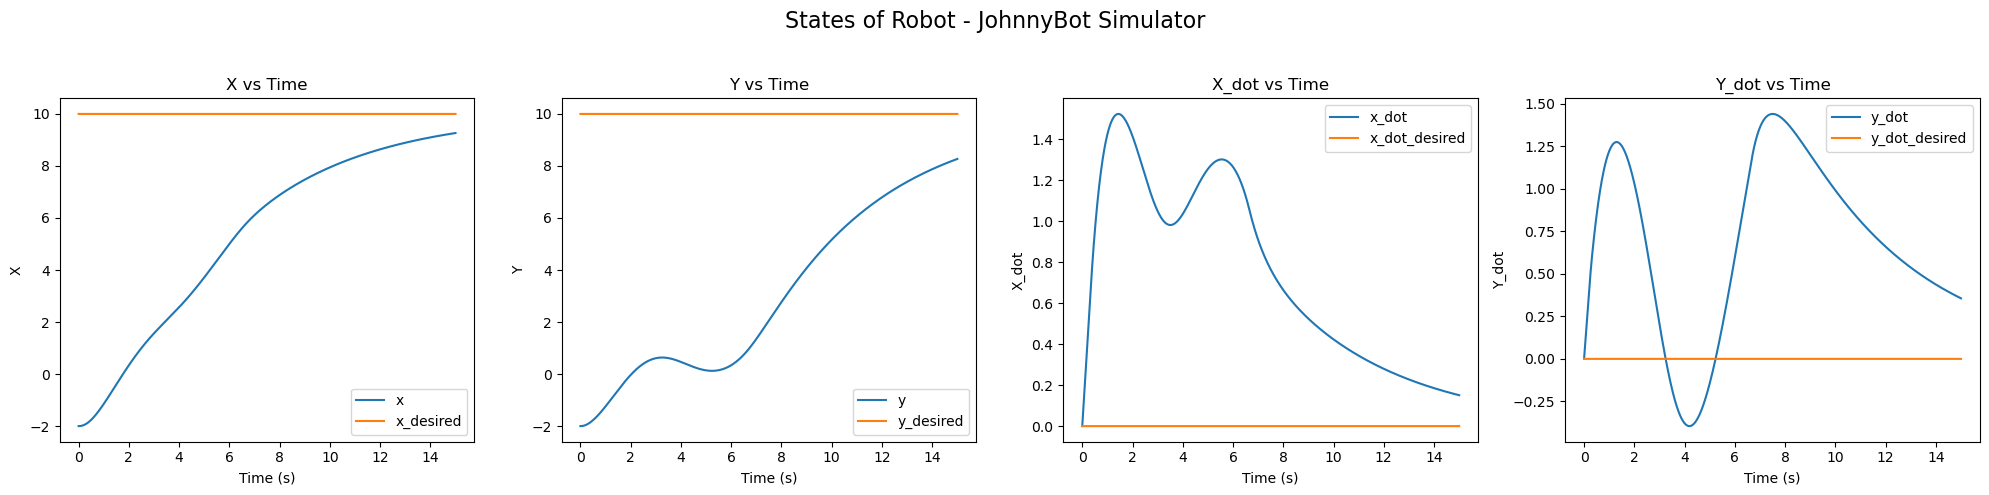

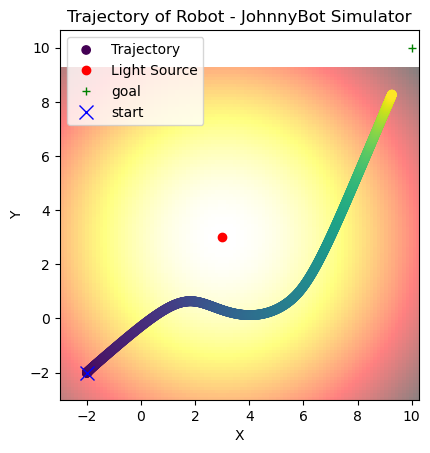

In [9]:
testA.plotter.source= [3,3]
testA.state0 = jnp.array([-2.0, -2.0, 0, 0])

testA.states = [testA.state0]
testA.controls = [testA.control]



# Define system matrices
A = np.array([[0, 0, 1, 0],
                [0, 0, 0, 1],
                [0, 0, 0, 0],
                [0, 0, 0, 0]])

B = np.array([[0, 0],
                [0, 0],
                [1, 0],
                [0, 1]])

# Time horizon
MPC_horizon = 20
testA.tf = 15
time_horizon = int(testA.tf / testA.dt)

testA.time = np.linspace(testA.t0, testA.tf, time_horizon)

testA.desired_states = np.tile(testA.desired_state, (time_horizon, 1))

# Define optimization variables
us = cp.Variable((2, MPC_horizon - 1))  # Control inputs [x_dot_dot, y_dot_dot]
states = cp.Variable((4, MPC_horizon))  # States [x, y, x_dot, y_dot]

state1 = cp.Parameter(4)
# Define optimization variables

db = cp.Parameter(2)
b = cp.Parameter(1)


As = cp.Parameter((4, 4)) # for later
As.project_and_assign(A)
Bs = cp.Parameter((4, 2)) # for later  
Bs.project_and_assign(B)


# Define Q and R matrices
Q = np.diag([2, 2, 1, 1])  # Penalize position error more than velocity error
R = np.diag([0.1, 0.1])  # Penalize control effort

# Define constraints list
constraints = []

# Initial state constraint
constraints.append(states[:, 0] == state1)

constraints.append(b + (db @ us) >= 0)

# Dynamics constraints
for t in range(MPC_horizon - 1):
    constraints.append(states[:, t + 1] == states[:, t] + (A @ states[:, t] + B @ us[:, t]) * testA.dt)
    


# Control input constraints
constraints.append(us[0, :] <= testA.max_acceleration)
constraints.append(us[0, :] >= testA.min_acceleration)
constraints.append(us[1, :] <= testA.max_acceleration)
constraints.append(us[1, :] >= testA.min_acceleration)



# Define the objective function (vectorized)
objective = cp.Minimize(
    cp.sum([cp.quad_form(states[:, t] - testA.desired_states[t, :], Q) for t in range(MPC_horizon)]) +
    cp.sum([cp.quad_form(us[:, t], R) for t in range(MPC_horizon - 1)])
)

# Solve the optimization problem
prob = cp.Problem(objective, constraints)

# Solve the problem iteratively
for i in range(time_horizon-1):

    new_state = testA.states[-1]
    new_control = testA.controls[-1]
    state1.project_and_assign(new_state)
    
    # b CBF constraint
    L2fb, LgLfb, Lfa1b, a2_term = control_constraint_degree_2(barrier_function, dynamics, new_state, new_control, [alpha1, alpha2])
    db.project_and_assign(LgLfb)
    b.project_and_assign(L2fb + Lfa1b + a2_term)
    
    # Solve the optimization problem
    result = prob.solve()

    # Check if the problem was solved successfully
    if prob.status == cp.OPTIMAL:
        print(f"Step {i}: Optimization successful!")
        print("Optimal cost:", result)

        # Append the first state and control input to the trajectories
        print("Optimal initial state trajectory:", states.value[:,0])
        print("Optimal state trajectory:", states.value[:,1])
        testA.states.append(states.value[:, 1])  # First state in the horizon
        testA.controls.append(us.value[:, 0])  # First control input in the horizon
    
    else:
        print(f"Step {i}: Optimization failed:", prob.status)
        break

testA.plot()
